# Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

## Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
from TCGame_Env import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt
import os
import time

In [2]:
policy_file_path = 'results/Policy.pkl'
rewards_file_path = 'results/Rewards.pkl'
states_file_path = 'results/States_tracked.pkl'

## Utility Functions

In [3]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [4]:
# Defining a function which will return valid (all possible actions) actions for the agent corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

#     valid_actions = []
    
#     valid_actions = [i for i in env.action_space(state)[0]]
    
    valid_actions = env.action_space(state)[0]
    return valid_actions

In [5]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state_key = Q_state(state)
    
    if state_key not in Q_dict.keys():
        valid_act = valid_actions(state)
        for action in valid_act:
            Q_dict[state_key][action]=0

In [6]:
# Print the state as a grid
def print_state_grid(state):
    for value,idx in enumerate(state):
        print(f' {value} ')
        if ((idx+1)%3 == 0):
            print(f'\n')

## Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [7]:
# max_epsilon = 1.0
# min_epsilon = 0.001
# episode_count = 50
# exp_value = 1/10**(len(str(episode_count))-1)
# time = np.arange(0,episode_count)
# epsilon = []
# for i in range(0,episode_count):
#     epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-exp_value*i))

In [8]:
# ### REFERENCE - FROM OTHER NOTEBOOK
# # Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy


# def epsilon_greedy(state, time):
#     epsilon = - 1/ (1 + np.exp((-time+7500000)/1700000)) + 1
#     z = np.random.random()
        
#     if z > epsilon:
#         action = max(Q_dict[state],key=Q_dict[state].get)   #Exploitation: this gets the action corresponding to max q-value of current state
#     else:
#         action = np.random.choice(np.arange(0,m+1))    #Exploration: randomly choosing and action
    
#     return action


In [23]:


def epsilon_greedy(state, episode_count, agent_action_space):
    
    max_epsilon = 1.0
    min_epsilon = 0.001
    exp_value = 1/10**(len(str(episode_count))-1)
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-exp_value*episode_count)
    z = np.random.random()
        
    if z > epsilon:
        print(f'4DEBUG: Exploit. State:{state}')
        action = max(Q_dict[Q_state(state)],key=Q_dict[Q_state(state)].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
        print(f'4DEBUG: Explore')
        action = random.choice(agent_action_space)    #Exploration: randomly choosing and action
    
    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [10]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)

States_track = collections.defaultdict(dict)

rewards_tracked = {'x-x-x-x-x-x-x-x-x':[],
                   'x-x-x-x-x-x-x-x-1':[], 
                   'x-x-x-x-x-x-x-x-2':[], 
                   'x-x-x-x-x-x-x-x-3':[], 
                   'x-x-x-x-x-x-x-x-4':[], 
                   'x-x-x-x-x-x-x-x-5':[],
                   'x-x-x-x-x-x-x-x-6':[], 
                   'x-x-x-x-x-x-x-x-7':[], 
                   'x-x-x-x-x-x-x-x-8':[],
                   'x-x-x-x-x-x-x-x-9':[]}



print(len(Q_dict))
print(len(rewards_tracked))
print(len(States_track))

0
10
0


In [11]:
# Initialise states to be tracked
def initialise_tracking_states():
    # Create the sample state-action pairs to be tracked
    sample_q_values = [('x-x-x-x-x-x-x-x-x',(0,9)),('x-x-x-x-x-x-x-x-1',(0,9)),('x-x-x-x-x-x-x-x-2',(0,9)),('x-x-x-x-x-x-x-x-3',(0,9)),('x-x-x-x-x-x-x-x-4',(0,9)),('x-x-x-x-x-x-x-x-5',(0,9)),('x-x-x-x-x-x-x-x-6',(0,9)),('x-x-x-x-x-x-x-x-7',(0,9)),('x-x-x-x-x-x-x-x-8',(0,9)),('x-x-x-x-x-x-x-x-9',(0,9))]    #select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []    #this is an array which will have appended values of that state-action pair for every 2000th episode
  
  
  

In [12]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [13]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [14]:
def load_files():
    with open(policy_file_path, 'rb') as handle:
        Q_dict = pickle.load(handle)

    with open(rewards_file_path, 'rb') as handle:
        rewards_tracked = pickle.load(handle)    

    with open(states_file_path, 'rb') as handle:
        States_track = pickle.load(handle)    

    print(len(Q_dict))
    print(len(rewards_tracked))
    print(len(States_track))

# START

In [15]:

    
# Check if pickle files exist
if os.path.isfile(policy_file_path) :
    print('Loading files')
    load_files()
else:
    print('Initialize states')
    initialise_tracking_states()

Initialize states


# TRAINING

## REFERENCE

In [16]:
# #Defining parameters for the experiment

# EPISODES = 20
# #EPISODES = 15000000
# STEPS = 2
# #STEPS = 30                 #for 30 days
# LR = 0.01                   #learning rate
# GAMMA = 0.91


# #threshold = 2000       #every these many episodes, the 4 Q-values will be stored/appended (convergence graphs)
# threshold = 1
# #policy_threshold = 30000    #every these many episodes, the Q-dict will be updated
# policy_threshold = 3

In [17]:
# #for episode in range(0,EPISODES):
# for episode in range(6393884,EPISODES):

    
#     env = InventoryEnv()      #creating an instance of the class
#     #this initialises the state back to some initial value which is required for every new episode
#     #this also initialises all parameters like m,p,K, etc.
    
#     initial_state = env.state    #for the purpose of tracking reward
#     curr_state = env.state     #note that we are starting on this day's evening because action is taken in the evening
#     #curr_state is state_mon
    
#     add_to_dict(curr_state,valid_actions(curr_state))
    
#     #reward is not calculated for the immediately next day
#     time_step = 0
#     reward = None
#     curr_action = np.random.choice(np.arange(0,m+1))    #randomly choosing and action
#     #curr_action is a_mon
    
#     next_state = env.initial_step(curr_state, curr_action)   #returned state_tue
    
#     add_to_dict(next_state,valid_actions(next_state))

#     curr_state = next_state       #state_tue became state(t-1)
    
#     #note that curr_state is always previous day evening's stock
    
#     total_reward = 0
    
    
#     while time_step < STEPS:    #the episode will run only for a few steps and not infinitely
        
#         #curr_action is a_tue and is a(t-1)      
#         curr_action = epsilon_greedy(curr_state, episode)
        
#         next_state, reward = env.step(curr_state, curr_action)
#         #next_state is state_wed 
        
#         add_to_dict(next_state,valid_actions(next_state))
            
#         # UPDATE RULE
#         max_next = max(Q_dict[next_state],key=Q_dict[next_state].get)   #this gets the action corresponding to max q-value of next state
#         Q_dict[curr_state][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state][max_next]))) - Q_dict[curr_state][curr_action] ) 


#         curr_state = next_state       #state(t) became state(t-1)

#         total_reward += reward
        
#         time_step += 1

    
#     #TRACKING REWARDS
#     if initial_state in rewards_tracked:     #storing rewards
#         rewards_tracked[initial_state].append(total_reward)
#         #save_obj(rewards_tracked,'Rewards')

#     if ((episode+1) % threshold) == 0:   #every 2000th episode
#         save_obj(rewards_tracked,'Rewards')   
    
#     #TRACKING Q-VALUES
#     if (episode == threshold-1):        #at the 1999th episode
#         initialise_tracking_states()
      
#     if ((episode+1) % threshold) == 0:   #every 2000th episode
#         save_tracking_states()
#         save_obj(States_track,'States_tracked')   
    
#     #SAVING POLICY
#     if ((episode+1)% policy_threshold ) == 0:  #every 30000th episodes, the Q-dict will be saved
#         save_obj(Q_dict,'Policy')    
        
        
# save_obj(rewards_tracked,'Rewards')   
# save_obj(States_track,'States_tracked')   
# save_obj(Q_dict,'Policy')      
# print(episode)

## ACTUAL

#### Define hyperparameters  ---write your code here

In [27]:
#Defining parameters for the experiment

EPISODES = 200
#EPISODES = 15000000
# STEPS = 2
#STEPS = 30                 #for 30 days
LR = 0.01                   #learning rate
GAMMA = 0.91


#threshold = 2000       #every these many episodes, the 4 Q-values will be stored/appended (convergence graphs)
threshold = 1
#policy_threshold = 30000    #every these many episodes, the Q-dict will be updated
policy_threshold = 3

### Q-update loop ---write your code here

Game is played 'EPISODES' number of times
Save some states_track for the plot

In [28]:
start_time = time.time()


for episode in range(0,EPISODES):

    
    env = TicTacToe()      #creating an instance of the class
    #this initialises the state back to some initial value which is required for every new episode
    #this also initialises all parameters like m,p,K, etc.
    
    
    initial_state = env.state    #for the purpose of tracking reward
    curr_state = env.state     #note that we are starting on this day's evening because action is taken in the evening
    has_reached_terminal = False
    
    print(f'Initial values: state:{env.state}')
    print(f'Initial values: all_possible_numbers:{env.all_possible_numbers}')
    
    add_to_dict(curr_state)
    
    #reward is not calculated for the immediately next day
    #time_step = 0
    #reward = None
    #curr_action = np.random.choice(np.arange(0,m+1))    #randomly choosing and action
    #curr_action is a_mon
    
#     next_state = env.initial_step(curr_state, curr_action)   #returned state_tue
    
#     add_to_dict(next_state,valid_actions(next_state))

#    curr_state = next_state       #state_tue became state(t-1)
    
    #note that curr_state is always previous day evening's stock
    
    total_reward = 0
    
    print(f'Initial Q-dict:{Q_dict}')
    
    # Run the episode till a result is reached or the game ends in a tie
    while (not has_reached_terminal):
        
        #print(f'4DEBUG:Agent action space:{env.action_space(curr_state)[0]}')
        
        # Get the current action - either exploit or explore   
        curr_action = epsilon_greedy(state = curr_state, episode_count = episode,  agent_action_space = env.action_space(curr_state)[0])
        
        print(f'4DEBUG: curr_state:{curr_state},curr_action :{curr_action}')
        
        
        next_state, reward, has_reached_terminal = env.step(curr_state, curr_action)
        
        add_to_dict(next_state)
        
        
        print(f'Updated Q-dict:{Q_dict}')
        print(f'4DEBUG: next_state:{next_state},reward :{reward},has_reached_terminal :{has_reached_terminal}')
            
        # UPDATE RULE
        
        if not has_reached_terminal:
        
            max_next = max(Q_dict[Q_state(next_state)],key=Q_dict[Q_state(next_state)].get)   #this gets the action corresponding to max q-value of next state
            print(f'4DEBUG: next_state:{next_state},max_next action:{max_next}')
            Q_dict[Q_state(curr_state)][curr_action] += LR * ((reward + (GAMMA*(Q_dict[Q_state(next_state)][max_next]))) - Q_dict[Q_state(curr_state)][curr_action] ) 
        else:
            print(f'4DEBUG: Terminal Reached')
            Q_dict[Q_state(curr_state)][curr_action] += LR * reward 
            


        curr_state = next_state       #state(t) became state(t-1)

        total_reward += reward
        
        #time_step += 1

    
    #TRACKING REWARDS
    if Q_state(initial_state) in rewards_tracked:     #storing rewards
        rewards_tracked[Q_state(initial_state)].append(total_reward)
        #save_obj(rewards_tracked,'Rewards')

    if ((episode+1) % threshold) == 0:   #every 2000th episode
        save_obj(rewards_tracked,'Rewards')   
    
    #TRACKING Q-VALUES
    if (episode == threshold-1):        #at the 1999th episode
        initialise_tracking_states()
      
    if ((episode+1) % threshold) == 0:   #every 2000th episode
        save_tracking_states()
        save_obj(States_track,'States_tracked')   
    
    #SAVING POLICY
    if ((episode+1)% policy_threshold ) == 0:  #every 30000th episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy') 
        
    print_state_grid(curr_state)
        

        
save_obj(rewards_tracked,'Rewards')   
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')      
print(episode)

elapsed_time = time.time() - start_time
print(f'elapsed_time:{elapsed_time}')

Initial values: state:[nan, nan, nan, nan, nan, nan, nan, nan, nan]
Initial values: all_possible_numbers:[1, 2, 3, 4, 5, 6, 7, 8, 9]
Initial Q-dict:defaultdict(<class 'dict'>, {'x-x-x-x-x-x-x-x-x': {(0, 1): -0.01, (0, 3): -0.01, (0, 5): -0.01, (0, 7): -0.01, (0, 9): -0.01, (1, 1): -0.01, (1, 3): -0.01, (1, 5): -0.01, (1, 7): -0.01, (1, 9): -0.01, (2, 1): -0.01, (2, 3): -0.01, (2, 5): -0.01, (2, 7): -0.01, (2, 9): -0.01, (3, 1): -0.01, (3, 3): -0.01, (3, 5): -0.01, (3, 7): -0.01, (3, 9): -0.01, (4, 1): -0.0199, (4, 3): -0.01, (4, 5): 0, (4, 7): 0, (4, 9): 0, (5, 1): 0, (5, 3): -0.01, (5, 5): -0.01, (5, 7): 0, (5, 9): 0, (6, 1): 0, (6, 3): -0.01, (6, 5): 0, (6, 7): 0, (6, 9): 0, (7, 1): 0, (7, 3): 0, (7, 5): 0, (7, 7): 0, (7, 9): 0, (8, 1): 0, (8, 3): 0, (8, 5): 0, (8, 7): 0, (8, 9): 0}, '1-x-x-x-4-x-x-x-x': {(1, 3): 0, (1, 5): 0, (1, 7): 0, (1, 9): 0, (2, 3): 0, (2, 5): 0, (2, 7): 0, (2, 9): 0, (3, 3): 0, (3, 5): 0, (3, 7): 0, (3, 9): 0, (5, 3): 0, (5, 5): 0, (5, 7): 0, (5, 9): 0, (6, 3

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Updated Q-dict:defaultdict(<class 'dict'>, {'x-x-x-x-x-x-x-x-x': {(0, 1): -0.0490099501, (0, 3): -0.0490099501, (0, 5): -0.0490099501, (0, 7): -0.0490099501, (0, 9): -0.0490099501, (1, 1): -0.0490099501, (1, 3): -0.0490099501, (1, 5): -0.0490099501, (1, 7): -0.0490099501, (1, 9): -0.0490099501, (2, 1): -0.0490099501, (2, 3): -0.0490099501, (2, 5): -0.0490099501, (2, 7): -0.0490099501, (2, 9): -0.0490099501, (3, 1): -0.0490099501, (3, 3): -0.0490099501, (3, 5): -0.0490099501, (3, 7): -0.0490099501, (3, 9): -0.058519850599, (4, 1): -0.0490099501, (4, 3): -0.0490099501, (4, 5): -0.0490099501, (4, 7): -0.0490099501, (4, 9): -0.0490099501, (5, 1): -0.0490099501, (5, 3): -0.0490099501, (5, 5): -0.0490099501, (5, 7): -0.0490099501, (5, 9): -0.0490099501, (6, 1): -0.0490099501, (6, 3): -0.0490099501, (6, 5): -0.0490099501, (6, 7): -0.0490099501, (6, 9): -0.0490099501, (7, 1): -0.0490099501, (7, 3): -0.0490099501, (7, 5): -0.0490099501, (7, 7): -0.0490099501, (7, 9): -0.0490099501, (8, 1): -0.0

In [0]:
# start_time = time.time()

# for episode in range(EPISODES):
#     ##### Start writing your code from the next line
    
    
    
    
    
    
    
    
    
    
# elapsed_time = time.time() - start_time
# save_obj(States_track,'States_tracked')   
# save_obj(Q_dict,'Policy')

#### Check the Q-dictionary

In [25]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -0.01,
              (0, 3): -0.01,
              (0, 5): -0.01,
              (0, 7): -0.01,
              (0, 9): -0.01,
              (1, 1): -0.01,
              (1, 3): -0.01,
              (1, 5): -0.01,
              (1, 7): -0.01,
              (1, 9): -0.01,
              (2, 1): -0.01,
              (2, 3): -0.01,
              (2, 5): -0.01,
              (2, 7): -0.01,
              (2, 9): -0.01,
              (3, 1): -0.01,
              (3, 3): -0.01,
              (3, 5): -0.01,
              (3, 7): -0.01,
              (3, 9): -0.01,
              (4, 1): -0.0199,
              (4, 3): -0.01,
              (4, 5): 0,
              (4, 7): 0,
              (4, 9): 0,
              (5, 1): 0,
              (5, 3): -0.01,
              (5, 5): -0.01,
              (5, 7): 0,
              (5, 9): 0,
              (6, 1): 0,
              (6, 3): -0.01,
              (6, 5): 0,
              (6, 7): 0,
         

In [26]:
len(Q_dict)

93

In [29]:
total_reward

-4

In [30]:
States_track

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 9): [-0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.01,
               -0.0199,
               -0.0199,
               -0.0199,
               -0.0199,
               -0.0199,
               -0.0199,
               -0.0199,
               -0.0199,
               -0.0199,
               -0.0199,
               -0.0199,
               -0.0199,
               -0.0199,
               -0.0199,
 

In [31]:
rewards_tracked

{'x-x-x-x-x-x-x-x-x': [-4,
  -4,
  7,
  6,
  -13,
  -4,
  -14,
  6,
  -13,
  -13,
  -4,
  -4,
  -14,
  7,
  -13,
  8,
  6,
  6,
  7,
  -14,
  -14,
  -4,
  -4,
  -4,
  6,
  -4,
  7,
  -4,
  -13,
  -4,
  -4,
  -4,
  -14,
  -13,
  -14,
  -4,
  -14,
  -4,
  7,
  -4,
  -4,
  -4,
  -12,
  -13,
  -13,
  -4,
  -4,
  -13,
  -4,
  6,
  -13,
  -14,
  -4,
  -4,
  -4,
  -4,
  -4,
  -4,
  -4,
  -13,
  6,
  -4,
  7,
  7,
  -4,
  6,
  7,
  -4,
  -14,
  -14,
  7,
  7,
  -14,
  -4,
  -4,
  -14,
  -13,
  -4,
  -14,
  -14,
  -12,
  -4,
  7,
  -4,
  -4,
  8,
  -14,
  -14,
  -4,
  -14,
  -4,
  6,
  -4,
  -13,
  -4,
  -4,
  7,
  -4,
  -4,
  6,
  -4,
  -4,
  -4,
  -14,
  6,
  -4,
  -4,
  7,
  7,
  -4,
  -4,
  -4,
  -14,
  8,
  -4,
  6,
  -4,
  6,
  -4,
  -14,
  7,
  6,
  7,
  8,
  -4,
  -4,
  -4,
  6,
  -4,
  -4,
  6,
  -12,
  -4,
  -4,
  -4,
  -4,
  -4,
  -4,
  -14,
  6,
  -4,
  8,
  -13,
  -14,
  7,
  -4,
  -4,
  6,
  -4,
  7,
  -4,
  -4,
  -14,
  -4,
  6,
  -4,
  -4,
  6,
  -4,
  -4,
  -14,
  -4,
  -4,
  -

In [32]:
rewards_tracked.get(rewards_tracked.keys()[0])

TypeError: 'dict_keys' object is not subscriptable

In [0]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated

#### Check the states tracked for Q-values convergence
(non-evaluative)

In [0]:
# Write the code for plotting the graphs for state-action pairs tracked

### Memory requirements

In [ ]:
#No. of state,action pairs
state_space = 51*51*7

print state_space

In [ ]:
#For tracking convergence, 4 Q-values will be tracked. These values are saved after every 2000 episodes.

no_of_q_values_tracked = 4*20000000/20000
#no_of_states_tracked = 4 * (20000000/2000) * 101

print no_of_q_values_tracked
#print no_of_states_tracked

### Epsilon - decay check

In [14]:
max_epsilon = 1.0
min_epsilon = 0.001
episode_count = 50
exp_value = 1/10**(len(str(episode_count))-1)
time = np.arange(0,episode_count)
epsilon = []
for i in range(0,episode_count):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-exp_value*i))

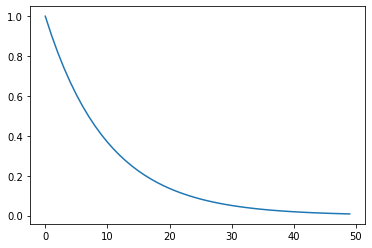

In [15]:

plt.plot(time, epsilon)
plt.show()

# TESTING

In [63]:
curr_state = [7, 2, 6,  np.NaN, 8, np.NaN, 14, np.NaN, 1]

In [65]:
winning_idx_lists = [
    [0, 1, 2],
    [3, 4, 5],
    [6, 7, 8],
    [0, 3, 6],
    [1, 4, 7],
    [2, 5, 8],
    [0, 4, 8],
    [2, 4, 6]
]
is_winning = False
for winning_idx_list in winning_idx_lists:
    result_list = [curr_state[index] for index in winning_idx_list]
    print(result_list)
    print(sum(result_list))
    #if (True not in np.isnan(result_list)) and ( sum(result_list) == 15):
    if (sum(result_list) == 15):
        is_winning = True 
        print(f"SUM 15 FOUND: {is_winning}")
        break

print(f"Is Winning: {is_winning}")

[7, 2, 6]
15
SUM 15 FOUND: True
Is Winning: True


In [67]:
curr_state = [1, 2, 3, 4, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN]
curr_action = [7, 9] 

curr_state[curr_action[0]] = curr_action[1]
print(curr_state) 

[1, 2, 3, 4, nan, nan, nan, 9, nan]


In [20]:
from itertools import product

a = [1,2,3]
b=[4,5]
out = list(product(a,b))
np.random.choice(out)

ValueError: a must be 1-dimensional

In [21]:
out

[(1, 4), (1, 5), (2, 4), (2, 5), (3, 4), (3, 5)]